# Project 2: Predicting Ontime Performance for Mystery Airline

#### Dennis Murray and Alex Deshowitz
#### MSDS ...


# Project Overview and Objectives

This project seeks to classify 2 main objectives:
  * **Ontime performance** - as defined by the DOT (see data dictionary for definition)
  
  * **D0** -  Whether a flight departs ontime
    
This task is a hard problem to solve.  We recognize that our dataset may not have all of the correct attributes to correctly and appropriately predict all scenarios.  In the real world, we would be able to iterate and add to our dataset.  However, for the sake of timliness and actually finishing this project and initial analysis, we will simply work with the attributes that we are given.  That being said, our objective is to best predict both D0 and ontime performance with the information that we have available.  Our hope is to leverage this information in order to add to and build better models in the future.

##### Modeling and Evaluation metrics

To evaluate the models that we attempted, we had to think about the ramifications of getting the answers incorrect.  We also had to consider that since we are trying to predict something that only happens 20% of the time (late flights) accuracy may not be the best choice for evaluation.  We may see levels that look unnecessarily good.  From the standpoint of the organization, false positives could be a huge problem.  The reasoning for this is because airlines plan schedules for crew, ground operations, gate operations, customer service operations both by the number of flights that are expected and the overall ontime percentage that is expected.  If a station expects that a higher than normal number of flights will be ontime, they will generally choose to use fewer staff members to work the flights, because the workload is theoretically lighter.  Additionally, if the operation is expected to perform rather poorly, the stations may choose to add an extra head or two to the schedule.  While it sounds as though adding additional people to the schedule could be expensive, the alternative under an unexpectedly poor performance scenario is that an entire shift of individuals could windup extending their workday at 2-3 times their normal pay rate.  The cost is essentially exponential.  Therefore we will be using both **accuracy** and **precision** to make our modeling decisions and recommendations.  However, we will also provide recall and F1.  

##### Cross Validation Methodology

For this model, we chose to use a 10-fold stratified cross validation.  There were several reasons for taking this approach.  First, this approach is generally a better scheme when thinking about bias and variance versus regular "holdout" cross-validation.  Additionally, for this modeling exercise, the class that we are modeling for OTP has an 80/20 distribution as in flights are generally ontime about 80% of the time.  Therefore, we wanted to hold the distribution of the classes constant in our modeling.  Stratified cross-validation allows us to keep the distribution of the classes the same within each fold of the data.  Therefore this is a really good approach given the classification variables at hand.

##### Other Notes

It might be noticed that some of the code for different models in this report is repeated.  This is not a naive approach to modeling.  This approach ensures that code blocks are not dependent upon previous code blocks that took an egregious about of time to render.



## Data Dictionary

#### Overview
This dataset contains one month of flight(leg) level information for an airline.  This dataset was created with the intent to forecast ontime performance for an airline.  Ontime performance as defined by the US department of transportation as any flight arriving within 15 minutes of its scheduled arrival time in the destination city

* **Origin** - The DOT airport code denoting the starting point of a flight leg (see link for list of codes:####)
* **Destination** - The DOT airport code denoting the ending point of a flight leg.  This list contains the same values as the origin field as an origin can be a destination and a destination can be an origin.  All airlines serve markets in this fashion.  For example, if Delta Airlines serves ATL-MSY (Dallas-New Orleans), they also serve the market in the opposite direction: MSY-ATL. 
* **Market** - A market is any origin and destination pair.  For example: ATL-TPA is a market.  Airlines always serve markets in a balanced fashion.  This means that if the airline serves ATL-MSY 11 times a day, the airline also serves the MSY-ATL 11 times a day.  The airline can still arbitrage the capacity in directions which have imbalanced demand patterns via changes in aircraft size (gauge).  For instance, Delta may serve MSY-ATL with 11 regional jets and ATL-MSY with 11 Boeing 757s (considerably larger aircraft). However, most airlines use far more sophisticated methods.  Markets tend to have time of day seat (gauge) patterns that attempt to best match demand patterns.  This means that we expect to see markets with mixed gauge patterns throughout the day.
* **Origin Latitude** - The latitude of the origin airport
* **Origin Longitude** - The longitude of the origin airport
* **Destination Latitude** - The latitude of the Destination airport
* **Destination Longitude** - The longitude of the Destination airport
* **Origin Country** - The country of origin for the flight leg.  Note that SJU (San Juan) is not included as international in this dataset per DOT specification.
* **Origin Country** - The destination country for the flight leg.  Note that SJU (San Juan) is not included as international in this dataset per DOT specification.
* **Flight Number** - Distinct number denoting a specific flight on a specific day.  While flight numbers can repeat on a day level, they cannot repeat at the same airport within 6 hours for obvious issues associated with the potential to have multiple flights in air with the same number at the same time from the same airline.  The number for scheduled flights ranges from 1-6999.  However, mistakes do happen, so it is best not to hard code filter any of these numbers.
* **Miles Flown** - Great circle mileage calculation for miles flown.  Note that this does not vary by market as this is simply the scheduled mileage and does not take into account flight path diversions.
* **Departure Date** - The date of departure between 5/1/2016 and 5/31/2016
* **Day of Week** - The day of week that a flight departs with 1 being equivalent to Monday
* **Flight Type Code** - One of 3 values indicating the flight type for DOT purposes.  This dataset was prefiltered to include only those types considered by the DOT for Ontime departures.
    * **Blank Value**- Records that have no value for the flight type code were scheduled flights that flew as scheduled
    * **Code S**- Records with flight type code S represent stub originator flights.  Stub originators are flights that were not scheduled to be originators on the flight line, but had an aircraft swap that made the route appear to have multiple orginator flights.  An originator is an aircraft's first flight of the day.  On average, aircraft in this dataset fly 6 flight legs per day.  A flight line could have both an originator and a stub originator with the given scenario.  Flight 1 on flight line number 150 from DAL-HOU departed HOU at 6am, and arrived in DAL at 7am.  The aircraft on flight route 150 was scheduled to continue on from HOU to ATL at 9am.  However, another flight line, say line 200, that was supposed to begin its day flying HOU-MCO at 8am had an aircraft go down for maintenance.  This line now has no aircraft to fly.  The dispatchers may decide that the aircraft on line 150 can take over line 200 and the aircraft on line 200 can take over line 150 because it leaves later and the maintenance issue can be fixed in time for the 9am HOU-ATL flight.  The flight that takes over line 150 is now considered a stub originator, flight type code 's.'  
    * **Code X**- Flight type code X denotes a flight that was cancelled.  Due to the sparse nature of the attributes in this dataset, we will calculate OTP with 
* **Flight Route Number**: The route number denotes an aircraft's line of flying for the day.  These will repeat for a given aircraft for a day for all flights in the flight line.
* **Route Sequence Number**: A number between 1 and 10 that denotes the aircraft's leg number on the flight line.
* **Aircraft Type Code** : The type of aircraft flying the flight.  All aircraft in this dataset are Boeing 737 variants
    *  WIll come back and fill these in later.  May need to change in the dataset.
* **Flight Cancellation code**: Code denoting the cancellation reason if the flight is cancelled.  Unlikely to use this for predictive purposes.
* **Alternate Airport**: If a flight has to divert for any reason to a different airport, this field will show the airport code where the aircraft landed
* **Push Delay Mins**: The number of minutes after the scheduled departure time that the aircraft pushed from the gate.  This is not used by the DOT.
* **Delay Type**: When a flight takes any type of departure delay, the departure station codes a reason for the delay.  The most common codes are : HD- some sort of hold, OP - operational, WX - weather, IF - inflight
* **Aircraft Tow Weight**: The weight of the aircraft prior to departure
* **Aicraft Landing Weight**: The standard landing weight of the aircraft.  This landing weight is aircraft specific and used for calculating landing fees at the destination airport.
* **Fuel Loaded**: Weight of the fuel loaded in thousands of pounds
* **Central Scheduled Departure Time**: Scheduled departure time of the aircraft in Central time.  
* **Local Scheduled Departure Time**: Scheduled departure time of the aircraft in Local time.  
* **Central Scheduled Arrival Time**: Scheduled arrival time of the aircraft in Central time. 
* **Local Scheduled Arrival Time**: Scheduled arrival time of the aircraft in Local time. 
* **Total Passengers**: Total number of people onboard the aircraft
* **Local Passengers**: The number of passengers traveling nonstop on the flight.  These people are not and will not be making a connection.
* **Connect Passengers**: The number of passengers making a connection at some point in their itinerary.
* **Thru Passengers**: The number of passengers onboard the aircraft who had flown on a previous flight on that aircraft and rather than making a connection stay on the aircraft.
* **Unaccompanied Minors**: The count of minors of age 5-11 not traveling with someone else at least age 12 or greater.
* **Total Nonrev Passengers**: The number of passengers onboard not paying a fare.  The individuals could be employees travleing for work or leisure, companion passholders, guest pass users, etc.
* **DOT Security Delay Time**: The delay time accounted for by security backups
* **NAS Delay Minutes**: The number of delay minutes due to National Airspace issues.
* **Weather Delay Minutes**: Delay minutes attributed to weather issues
* **DOT Delay Minutes**: Difference between actual arrival time and the scheduled arrival time.
* **Flight attendant change Indicator**: Field indicating whether there was a crew change for the flight attendants on a flight
* **Total Bags** : The number of checked bags on the flight
* **Bag Weight**: The weight of the bags on the flight
* **Freight Weight Total**: The weight of the total freight onboard the aircraft
* **Scheduled Turn Minutes**: The scheduled amount of time in the origin city that the ground grew has to unload passengers and bags, load passengers and bags, refuel, restock, and prep the plane for the next departure.
* ** Itins In**: The total number of itineraries scheduled that could have inbound connections on the leg.  
* ** Itins Out**: The total number of itineraries that the flight connects to
* ** Total Itins on Leg**: The total number of possible itineraries on the flight leg.  This number is not necessarily the aggregation of itins in and itins out.  There are nuances that can cause this number to be slightly higher or lower since an itin in can also be an itin out.



In [49]:
# import packages

import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
import sklearn as sk
import statsmodels.api as sm
#import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pandas as pd
from pandas.tools.plotting import scatter_plot
from pandas.tools.plotting import scatter_matrix

from sklearn.preprocessing import scale, StandardScaler
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression, Lasso, Lars, SGDRegressor

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


#import locale
#locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

from pandas.tools.plotting import scatter_matrix

from sklearn.svm import SVR
from sklearn.feature_selection import RFE, RFECV

from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline


#configure the random seed so we our randomness is reproducible for selection of learn/test sets
np.random.seed(0)

%matplotlib inline

In [25]:
#read in the data file
OnTime=pd.read_csv("Data/20170112_DataMiningI_TestDataSet_v01.csv", header=0)

In [26]:
# look at datatypes
OnTime.dtypes

origin                         object
origin_latitude               float64
origin_longitude              float64
destination                    object
destination_latitude          float64
destination_longitude         float64
origin_country                 object
destination_country            object
flight_number                   int64
miles_flown                     int64
departure_date                 object
day_of_week                     int64
flight_type_code               object
flight_route_number             int64
route_sequence_number           int64
aircraft_type_cde               int64
flight_cancellation_code       object
alternate_airport              object
push_delay_mins                 int64
delay_type                     object
delay_id                       object
aircraft_seat_count             int64
aircraft_tow_weight             int64
aircraft_landing_weight         int64
fuel_loaded                     int64
central_scheduled_dep_time      int64
local_schedu

In [27]:
OnTime['flight_type_code'].describe()

count     112059
unique         3
top             
freq      110711
Name: flight_type_code, dtype: object

# Data Cleaning

The first thing we want to get rid of in this dataset is cancelled flights.  While a cancelled flight is technically not considered ontime, the data in this set is too sparse to forecast cancellations. We would need additional attributes to be able to forecast cancellations

In [29]:
len(OnTime) - len(OnTime.loc[OnTime['flight_type_code']!= 'X'])

1004

looks like we are filtering out about 1004 records

In [30]:
OnTime = OnTime.loc[OnTime['flight_type_code']!= 'X']

In [31]:
OnTime['flight_type_code'].describe()

count     111055
unique         2
top             
freq      110711
Name: flight_type_code, dtype: object

Now we have a dataset that excludes those sparse records.

The route sequence number is loaded into the file as a multiple of one-hundred million.  We would like this to be a more readable format.  Additionally, it makes more notional sense given that this value is the sequence number in the line.  Therefore a number between 1 and 10 makes sense to display

In [32]:
# need to fix route sequence number

#print(OnTime['route_sequence_number'].unique(), (OnTime['route_sequence_number']/100000000).unique())

print((OnTime['route_sequence_number']/100000000).head())

0    3.0
1    2.0
2    7.0
3    3.0
4    6.0
Name: route_sequence_number, dtype: float64


In [33]:
OnTime['route_sequence_number'] = OnTime['route_sequence_number']/100000000

print(OnTime['route_sequence_number'].head(), OnTime['route_sequence_number'].unique())


0    3.0
1    2.0
2    7.0
3    3.0
4    6.0
Name: route_sequence_number, dtype: float64 [  3.   2.   7.   6.   1.   5.   4.   9.  10.   8.]


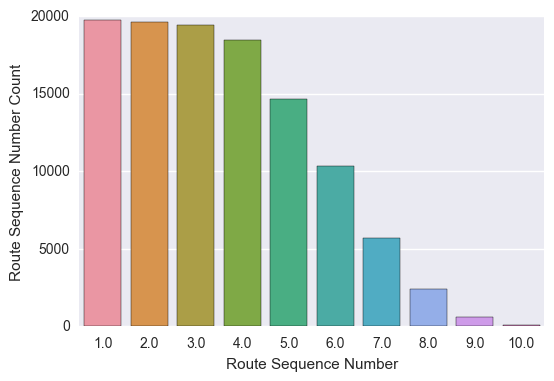

In [34]:
ax  = sns.countplot(OnTime['route_sequence_number'])
ax = plt.ylabel('Route Sequence Number Count')
ax = plt.xlabel('Route Sequence Number')
plt.show()

The countplots look good with the removal of the cancelled flights.  Previously, we had some route sequence numbers >10.  This is not possible, because the most legs a line can contain in this dataset is 10

In [35]:
#Create indicator for ontime performance, where 1 = OnTime and 0 = LATE
OnTime['OnTimeIndicator'] = np.where(OnTime['dot_delay_mins']>=15, 0, 1)

#############################
## THINK I FIXED THESE ISSUES>>> there were commas in the excel formatting of these columns will send good file

#Need to fix the time of day first
#OnTime['local_scheduled_dep_time']=OnTime['local_scheduled_dep_time'].apply(locale.atoi)

#Fix weight fields to be numeric
#OnTime['bag_weight_total']=OnTime['bag_weight_total'].apply(locale.atoi)
#OnTime['freight_weight_total']=OnTime['freight_weight_total'].apply(locale.atoi)
#OnTime['aircraft_landing_weight']=OnTime['aircraft_landing_weight'].apply(locale.atoi)
#OnTime['aircraft_tow_weight']=OnTime['aircraft_tow_weight'].apply(locale.atoi)
#OnTime['miles_flown']=OnTime['miles_flown'].apply(locale.atoi)


The DOT defines a flight as being on time if it arrives within 15 minutes of the scheduled arrival time.

We need to create time of day buckets.  Luckily there are predefined bins that we can use.

In [36]:
#Need some Time of Day buckets
OnTime['TimeBucket']=pd.cut(OnTime['local_scheduled_dep_time'],[0, 600, 700, 1200, 2000, 2200,2800],6, 
       labels=["deep_shoulder_am", "shoulder_am", "am_meat", "pm_meat", "shoulder_pm","deep_shoulder_pm"])

# test the variable

print(OnTime[['local_scheduled_dep_time','TimeBucket']].head())

   local_scheduled_dep_time   TimeBucket
0                      1205      pm_meat
1                       925      am_meat
2                      2200  shoulder_pm
3                      1105      am_meat
4                      1825      pm_meat


It looks like this variable is working well

In [37]:
#Need an "International" code
OnTime['International'] = np.where(OnTime['origin_country']!=OnTime['destination_country'], 1, 0)

In [38]:
print(OnTime['origin_country'], OnTime['destination_country'], OnTime['International'])

0         United States of America
1         United States of America
2         United States of America
3         United States of America
4         United States of America
5         United States of America
6         United States of America
7         United States of America
8         United States of America
9         United States of America
10        United States of America
11        United States of America
12        United States of America
13        United States of America
14        United States of America
15        United States of America
16        United States of America
17        United States of America
18        United States of America
19        United States of America
20        United States of America
21        United States of America
22        United States of America
23        United States of America
24        United States of America
25        United States of America
26        United States of America
27        United States of America
28        United Sta

We also need to look at the FA change indicator.  It looked suspect in previous work.

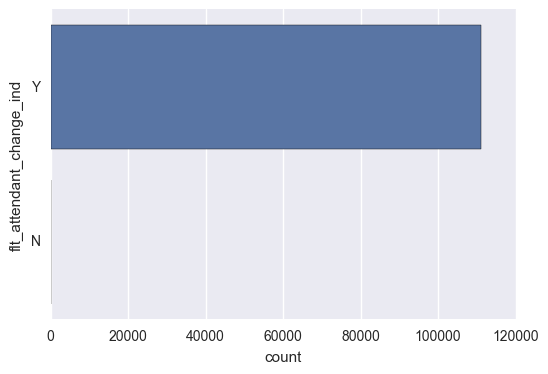

In [39]:
#OnTime['flt_att_chg'] = np.where(OnTime['flt_attendant_change_ind'] == 'Y', 1, 0)
#print(OnTime[['flt_att_chg','flt_attendant_change_ind']].tail(100))
ax = sns.countplot(y =  OnTime['flt_attendant_change_ind'])

plt.show()


In [40]:
# we need to drop FA change because it is nearly all Y, which isn't possible.
del OnTime['flt_attendant_change_ind']

In [41]:
# add an originator indicator

OnTime['Originator_ind'] = np.where(OnTime['route_sequence_number']== 1.0,1,0)

print(OnTime[['Originator_ind','route_sequence_number']].head(10))

   Originator_ind  route_sequence_number
0               0                    3.0
1               0                    2.0
2               0                    7.0
3               0                    3.0
4               0                    6.0
5               1                    1.0
6               0                    7.0
7               0                    2.0
8               0                    5.0
9               0                    2.0


In [42]:
# add D0 for other classification problem

OnTime['D_zero_ind'] = np.where(OnTime['push_delay_mins']== 0,1,0)

print(OnTime[['D_zero_ind','push_delay_mins']].head(10))

   D_zero_ind  push_delay_mins
0           0                6
1           1                0
2           0                9
3           0                2
4           1                0
5           0               23
6           1                0
7           1                0
8           1                0
9           1                0


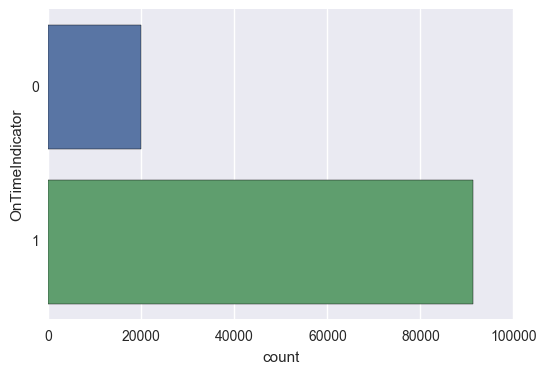

In [43]:
#show classes, we need to ensure there isn't a major class imbalance
ax = sns.countplot(y =  OnTime['OnTimeIndicator'])

plt.show()

This is actually probably a big enough class imbalance that we need to address it and possibly boost for late flights.

However, we do know that we are trying to predict something that happens 20% of the time or so.  We also know that there is a higher cost to predicting false positives.  The operation at the airline will ultimately plan staffing, gating, and shift schedules based on both the schedule and our prediction of ontime performance.  Therefore, if we predict that the airline will run ontime, and it doesnt we will potentially cost the company a great deal of money in overtime (up to 3X pay).  Therefore, it probably makes sense to look at both accuracy and precision in our resultset.  We could make the argument for recall.  However, it is much more expensive to pay an entire staff triple-time than to have a few extra folks on hand.  While no scenario is ideal, the first is the most costly.  

In [21]:
OnTime.columns.values

array(['origin', 'origin_latitude', 'origin_longitude', 'destination',
       'destination_latitude', 'destination_longitude', 'origin_country',
       'destination_country', 'flight_number', 'miles_flown',
       'departure_date', 'day_of_week', 'flight_type_code',
       'flight_route_number', 'route_sequence_number', 'aircraft_type_cde',
       'flight_cancellation_code', 'alternate_airport', 'push_delay_mins',
       'delay_type', 'delay_id', 'aircraft_seat_count',
       'aircraft_tow_weight', 'aircraft_landing_weight', 'fuel_loaded',
       'central_scheduled_dep_time', 'local_scheduled_dep_time',
       'central_scheduled_arr_time', 'local_schedulced_arr_time',
       'total_passengers', 'local_passengers', 'connecting_passengers',
       'thru_passengers', 'unaccompanied_minors',
       'total_nonrev_passengers', 'dot_security_delay_time',
       'NAS_delay_minutes', 'weather_delay_minutes', 'dot_delay_mins',
       'total_bags', 'bag_weight_total', 'freight_weight_total',
    

In [22]:
#One Hot Encode any categorical variables
#Definitely origin and destination variables
#Aircraft Code

##### NOTE ####

# I am thinking that origin and destination may not need to be one-hot coded, because we have the lat/long, using a 
# standardized version of these should be enough and would remove some of hte sparsity from the dataset.
# Also, I would recommend that we take the delay code information out of the model since we will not know what these values
# are ahead of the forecast time- These are added after the fact so we would have to build a forecast of these values

cols_to_encode = ['origin', 'destination', 'aircraft_type_cde', 'day_of_week', 'TimeBucket', 
                  'flight_type_code', 'International', 'delay_type', 'delay_id']
OnTime = pd.get_dummies(OnTime,columns = cols_to_encode)

In [44]:
####################################
###### ALTERNATE ONE HOT CODE ######
####################################

cols_to_encode = ['aircraft_type_cde', 'day_of_week', 'TimeBucket', 
                'International']
OnTime = pd.get_dummies(OnTime,columns = cols_to_encode)


In [45]:
OnTime.describe()

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,flight_number,miles_flown,flight_route_number,route_sequence_number,push_delay_mins,aircraft_seat_count,...,day_of_week_6,day_of_week_7,TimeBucket_deep_shoulder_am,TimeBucket_shoulder_am,TimeBucket_am_meat,TimeBucket_pm_meat,TimeBucket_shoulder_pm,TimeBucket_deep_shoulder_pm,International_0,International_1
count,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,...,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000,111055.000000
mean,36.000711,-97.204804,36.003330,-97.208694,2135.389123,760.316618,312.861069,3.527720,3.829841,146.832687,...,0.105317,0.150547,0.039908,0.068858,0.304804,0.477871,0.092207,0.016352,0.980289,0.019711
std,5.055974,16.076966,5.059994,16.090650,1365.850855,464.998176,181.796940,1.931696,13.977466,11.447985,...,0.306963,0.357608,0.195744,0.253213,0.460326,0.499512,0.289319,0.126827,0.139006,0.139006
min,9.992500,-122.595000,9.992500,-122.595000,1.000000,137.000000,1.000000,1.000000,0.000000,122.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.846940,-115.158890,32.846940,-115.158890,939.000000,377.000000,158.000000,2.000000,0.000000,143.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,36.079720,-95.278610,36.079720,-95.278610,2110.000000,650.000000,316.000000,3.000000,0.000000,143.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,39.858330,-83.344440,39.858330,-83.344440,3118.000000,997.000000,464.000000,5.000000,2.000000,143.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,47.620000,-66.002220,47.620000,-66.002220,6980.000000,2627.000000,647.000000,10.000000,779.000000,175.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


When we look at our new one-hot coded values, they make sense.  We expect between 20% - 23% of all flights to be in the shoulder periods and that is exactly what we have here.  We also see that about 2% of the flights are international flights.  This is reflective of the 'mystery' airline's network structure.  we also see an accurate representation in the day of week buckets.  Therefore the data looks pretty clean now.

# Variable selection for Modeling

We know that there are some fields that should not be included in the model for several reasons:
    1.) They have no statistical bearing
    2.) They are too hard to model
    3.) Contextually, we would not have this information available to us at the time of forecasting (pre-flight)

With this in mind we will select those variables accordingly.

**Selected Variables**:
    
    * origin lat/long
    2.) destination lat/long
    3.) miles_flown
    4.) one hot encoded day of week
    5.) route_sequence_number
    6.) originator_indicator
    7.) one hot encoded aircraft type
    8.) push delay minutes - remember this is different than DOT delay mins
    9.) aircraft_seat_count
    10.) aircraft tow weight
    11.) fuel loaded
    12.) local scheduled departure time
    13.) total passengers
    14.) local passengers
    15.) connecting passengers
    16.) thru passengers
    17.) unaccompanied minors
    18.) total nonrev passengers
    19.) total bags
    20.) bag weight total
    21.) freight weight total
    22.) scheduled turn minutes
    23.) itins in
    24.) itins out
    25.) itins on leg
 
    


In [46]:
#Y set: 
Y=np.array(OnTime['OnTimeIndicator'])


#columnstotake=np.r_[1, 2, 3, 4, 8, 14, 15, 16, 17, 18, 25:30, 31:40, 41:285]
#columnstotake=np.r_[1, 2, 3, 4, 8, 14, 15, 16, 17, 18, 25:30]

columnstotake = np.r_[2, 3, 5, 6, 10, 14, 17, 20, 23, 25, 28:34, 38:45, 46, 48:68]
columnstotake = columnstotake - 1

#X Set:
#X=OnTime.ix[:, [-'OnTimeIndicator']]
X=OnTime.ix[:,columnstotake]
X.columns.values

array(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'miles_flown', 'route_sequence_number',
       'push_delay_mins', 'aircraft_seat_count', 'fuel_loaded',
       'local_scheduled_dep_time', 'total_passengers', 'local_passengers',
       'connecting_passengers', 'thru_passengers', 'unaccompanied_minors',
       'total_nonrev_passengers', 'total_bags', 'bag_weight_total',
       'freight_weight_total', 'scheduled_turn_minutes', 'itins_in',
       'itins_out', 'itins_on_leg', 'Originator_ind',
       'aircraft_type_cde_2', 'aircraft_type_cde_3', 'aircraft_type_cde_5',
       'aircraft_type_cde_6', 'aircraft_type_cde_8', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'day_of_week_7', 'TimeBucket_deep_shoulder_am',
       'TimeBucket_shoulder_am', 'TimeBucket_am_meat',
       'TimeBucket_pm_meat', 'TimeBucket_shoulder_pm',
       'TimeBucket_deep_shoulder_pm', 'Internation

In [47]:
# OnTime.dtypes - was just here for audit

In [145]:
####################################
######## ORIGINAL CODING ###########
####################################

#Define our X and Y Sets

#Y set: 
Y=np.array(OnTime['OnTimeIndicator'])



columnstotake=np.r_[1, 2, 3, 4, 8, 14, 15, 16, 17, 18, 25:30, 31:40, 41:285]
#columnstotake=np.r_[1, 2, 3, 4, 8, 14, 15, 16, 17, 18, 25:30]

columnstotake = columnstotake - 1

#X Set:
#X=OnTime.ix[:, [-'OnTimeIndicator']]
X=OnTime.ix[:,columnstotake]
X.columns.values

array(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'miles_flown', 'push_delay_mins',
       'aircraft_seat_count', 'aircraft_tow_weight',
       'aircraft_landing_weight', 'fuel_loaded', 'connecting_passengers',
       'thru_passengers', 'unaccompanied_minors',
       'total_nonrev_passengers', 'dot_security_delay_time',
       'weather_delay_minutes', 'dot_delay_mins', 'total_bags',
       'bag_weight_total', 'freight_weight_total',
       'scheduled_turn_minutes', 'itins_in', 'itins_out', 'itins_on_leg',
       'origin_ABQ', 'origin_ALB', 'origin_AMA', 'origin_ATL',
       'origin_AUA', 'origin_AUS', 'origin_BDL', 'origin_BHM',
       'origin_BNA', 'origin_BOI', 'origin_BOS', 'origin_BUF',
       'origin_BUR', 'origin_BWI', 'origin_BZE', 'origin_CAK',
       'origin_CHS', 'origin_CLE', 'origin_CLT', 'origin_CMH',
       'origin_CRP', 'origin_CUN', 'origin_DAL', 'origin_DAY',
       'origin_DCA', 'origin_DEN', 'origin_DSM', 'origin_DT

# Modeling - Classification Task 1 - DOT Ontime Performance

### Logistic Regression

In [84]:
%%time
# first attempt with defaults

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit

yhat = np.zeros(Y.shape) # we will fill this with predictions

scl = StandardScaler() # import the standardscaler
XScl = scl.fit_transform(X) # scale the x-variables

cv = StratifiedKFold(n_splits=10) 

clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for train, test in cv.split(XScl,Y):
    clf.fit(XScl[train],Y[train])
    yhat[test] = clf.predict(XScl[test])

total_accuracy_log_reg_1 = mt.accuracy_score(Y,yhat)
conf_matrix_1 = mt.confusion_matrix(Y,yhat)

precision = conf_matrix_1[0,0] / (conf_matrix_1[0,0]+ conf_matrix_1[1,0])
recall = conf_matrix_1[0,0] / (conf_matrix_1[0,0]+ conf_matrix_1[0,1])
f_measure = (2* conf_matrix_1[0,0]) / ((2* conf_matrix_1[0,0])+ conf_matrix_1[0,1] + conf_matrix_1[1,0])

print('-------------------------------')
print('Logistic Regression Output')
print( total_accuracy_log_reg_1)
print(conf_matrix_1)
print('Precision: ',precision, 'Recall: ',recall, 'F-measure: ', f_measure)


-------------------------------
Logistic Regression Output
0.864823735987
[[ 6840 13000]
 [ 2012 89203]]
Precision:  0.772706732942 Recall:  0.344758064516 F-measure:  0.476787954831
Wall time: 14.5 s


In [82]:
%%time
# using a gridsearch on logistic regression to solve for 'C' with accuracy as a target measure

# source: http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html

from sklearn.model_selection import GridSearchCV

yhat = np.zeros(Y.shape)

cv = 10 # the model does stratified k-fold by default

tuned_parameters = [{'C': [0.5, 1, 10, 100, 1000]}]

scores = ['accuracy','precision','recall',]
                    
for score in scores:
    clf = GridSearchCV(LogisticRegression(penalty='l2', C=0.5, class_weight=None), param_grid = tuned_parameters, cv= cv,
                       scoring= 'accuracy')
    clf.fit(XScl[train],Y[train])
    
    print('the best parameters solving for', score,' are: ', clf.best_params_)



the best parameters solving for accuracy  are:  {'C': 1}
the best parameters solving for precision  are:  {'C': 1}
the best parameters solving for recall  are:  {'C': 1}


In [85]:
%%time

# this model looks like the best.  Let's see which variables are most important.


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit

yhat = np.zeros(Y.shape) # we will fill this with predictions

scl = StandardScaler() # import the standardscaler
XScl = scl.fit_transform(X) # scale the x-variables

cv = StratifiedKFold(n_splits=10) 

clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None)

for train, test in cv.split(XScl,Y):
    clf.fit(XScl[train],Y[train])
    yhat[test] = clf.predict(XScl[test])

total_accuracy_log_reg_1 = mt.accuracy_score(Y,yhat)
conf_matrix_1 = mt.confusion_matrix(Y,yhat)

precision = conf_matrix_1[0,0] / (conf_matrix_1[0,0]+ conf_matrix_1[1,0])
recall = conf_matrix_1[0,0] / (conf_matrix_1[0,0]+ conf_matrix_1[0,1])
f_measure = (2* conf_matrix_1[0,0]) / ((2* conf_matrix_1[0,0])+ conf_matrix_1[0,1] + conf_matrix_1[1,0])

print('-------------------------------')
print('Logistic Regression Output')
print( total_accuracy_log_reg_1)
print(conf_matrix_1)
print('Precision: ',precision, 'Recall: ',recall, 'F-measure: ', f_measure)

-------------------------------
Logistic Regression Output
0.864823735987
[[ 6840 13000]
 [ 2012 89203]]
Precision:  0.772706732942 Recall:  0.344758064516 F-measure:  0.476787954831
Wall time: 14.3 s


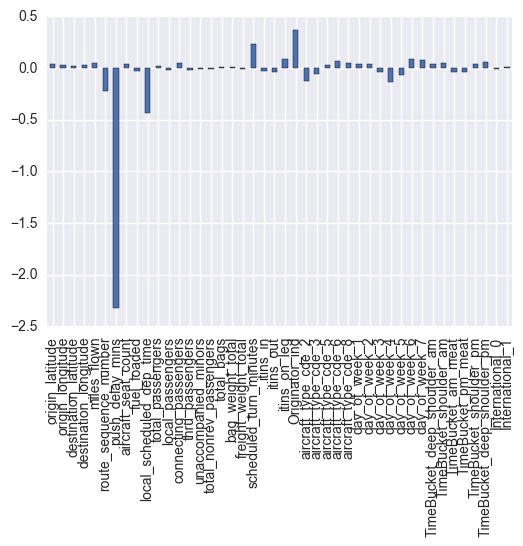

In [122]:

weights = pd.Series(clf.coef_[0], index = list([np.array(X.columns.values)]))

#weights = pd.Series(clf.coef_, index = list([np.array(X.columns.values)]))

ax = weights.plot(kind = 'bar')



#### Commentary

In the initial run. we were able to get 86% accuracy with the scaled variables.  That being said, we cheated a little bit by including the push delay minutes as part of the X-variables dataset.  This could be a really good forecasting methodology when we are trying to predict at the origin airport whether or not a flight will be delayed.  However, for longer term planning, this variable will not be known.  We also ran a grid search on this logistic regression solving for c and found that the default value of 1 seems to be the best parameter for regularization.  In this case, given that we have a great deal of observations, this is not all that surprising, because we would expect that we might be including more values than necessary by widening the parameter.

##### Weights
The weight interpretation is very interesting for this model. As mentioned before, we cheated a little bit by including push delays in predicting ontime performance, and we see that this is the most important variable in the dataset.  However, another very important term is the scheduled departure time.  This makes a ton of sense.  We know that OTP varies by time of day and that the mere intrinsic property of being at a certain time of day means that more things tend to go wrong and hence OTP suffers.  We also notice that whether a flight is an originator is very important.  These have a very high OTP.  The amount of turn time is also important in the model.  Also, this makes sense.  The more time you have to turn an aircraft, the more likely you are to be ontime.  It also looks like the number of connecting passgengers, while a relatively low weight, plays an important role in the model.  Additionally, the miles flown makes a huge difference in the OTP as well.  Given these results, we may remove the departure delay minutes and see if we get the same results.

# Logistic Regression 2

In this run, we remove the telltale variable of delay minutes to see what impacts that has on the model.

In [179]:
%%time
#reset the variables by removing delay minutes
columnstotake = np.r_[2, 3, 5, 6, 10, 14, 20, 23, 25, 28:34, 38:45, 46, 48:68]
columnstotake = columnstotake - 1



X=OnTime.ix[:,columnstotake]


scl = StandardScaler() # import the standardscaler
XScl = scl.fit_transform(X) # scale the x-variables



cv = 10 # the model does stratified k-fold by default

tuned_parameters = [{'C': [0.5, 1, 10, 100, 1000]}]

scores = ['accuracy','precision','recall']
                    
for score in scores:
    clf = GridSearchCV(LogisticRegression(penalty='l2', C=0.5, class_weight=None), param_grid = tuned_parameters, cv= cv,
                       scoring= 'accuracy')
    clf.fit(XScl[train],Y[train])
    
    print('the best parameters solving for', score,' are: ', clf.best_params_)


the best parameters solving for accuracy  are:  {'C': 10}
the best parameters solving for precision  are:  {'C': 10}
the best parameters solving for recall  are:  {'C': 10}
Wall time: 3min


It looks like C = 10 is the best regularization to use.  We run our previous model to see what everything looks like.  This is very encouraging since we took out our heaviest weighting from the previous model.

In [160]:
%%time

scl = StandardScaler() # import the standardscaler
XScl = scl.fit_transform(X) # scale the x-variables

yhat = np.zeros(Y.shape)

cv = StratifiedKFold(n_splits=10) 

clf = LogisticRegression(penalty='l2', C=10.0, class_weight=None)

for train, test in cv.split(XScl,Y):
    clf.fit(XScl[train],Y[train])
    yhat[test] = clf.predict(XScl[test])

total_accuracy_log_reg_2 = mt.accuracy_score(Y,yhat)
conf_matrix_2 = mt.confusion_matrix(Y,yhat)

precision_2 = conf_matrix_2[0,0] / (conf_matrix_2[0,0]+ conf_matrix_2[1,0])
recall_2 = conf_matrix_2[0,0] / (conf_matrix_2[0,0]+ conf_matrix_2[0,1])
f_measure_2 = (2* conf_matrix_2[0,0]) / ((2* conf_matrix_2[0,0])+ conf_matrix_2[0,1] + conf_matrix_2[1,0])

print('-------------------------------')
print('Logistic Regression Output')
print( total_accuracy_log_reg_2)
print(conf_matrix_2)
print('Precision: ',precision, 'Recall: ',recall, 'F-measure: ', f_measure)

-------------------------------
Logistic Regression Output
0.822007113592
[[  387 19453]
 [  314 90901]]
Precision:  0.351241587375 Recall:  0.152570564516 F-measure:  0.212734556188
Wall time: 11.7 s


Well, we now see a very large drop in our precision.  Just like we talked about in class, this is concerning.  It means that when something is ontime, we are only predicting flights that are ontime correctly 55% of the time, the rest of the time, we incorrectly classify them as DOT late.

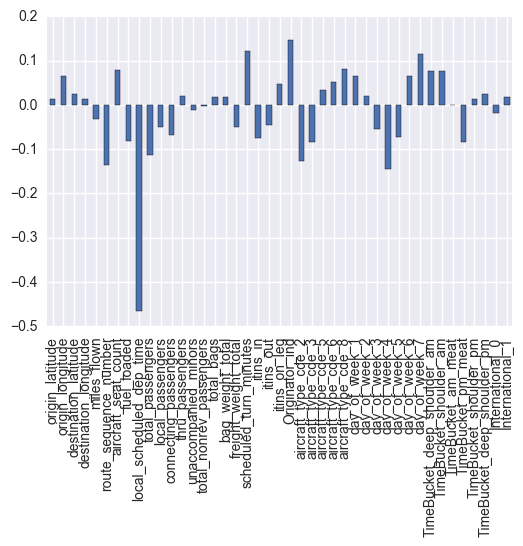

In [129]:
weights = pd.Series(clf.coef_[0], index = list([np.array(X.columns.values)]))

#weights = pd.Series(clf.coef_, index = list([np.array(X.columns.values)]))

ax = weights.plot(kind = 'bar')

#### Commentary

Well, we now see a very large drop in our precision.  Just like we talked about in class, this is concerning.  It means that when something is ontime, we are only predicting flights that are ontime correctly 55% of the time, the rest of the time, we incorrectly classify them as DOT late.

##### Weights
The weights are very interesting in this case.  We see that the local departure time is very important, along with whether a flight is an originator.  We see that the am shoulder and the PM meat are very important in the time of say realm.  We also see that the route sequence number is very important in this case as well.  The turn minutes continue to be an important factor as well.  Additionally, Thursdays seem to be a day of week that could be scrutinized further.



# KNN classifier

We know that KNN suffers from the curse of dimensionality and that we should probably trim our dataset down a bit prior to running this classifier; however, let's just take a run with this one to see how long it takes.  We can modify subsequent models.

In [157]:
%%time
# Trying a regular KNN - takes 16 minutes DO NOT RERENDER

from sklearn.neighbors import KNeighborsClassifier

yhat = np.zeros(Y.shape)

cv = StratifiedKFold(n_splits=10) 

clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric = 'euclidean')

for train, test in cv.split(XScl,Y):
    clf.fit(XScl[train],Y[train])
    yhat[test] = clf.predict(XScl[test])

total_accuracy_3 = mt.accuracy_score(Y,yhat)
conf_matrix_3 = mt.confusion_matrix(Y,yhat)

precision = conf_matrix_3[0,0] / (conf_matrix_3[0,0]+ conf_matrix_3[1,0])
recall = conf_matrix_3[0,0] / (conf_matrix_3[0,0]+ conf_matrix_3[0,1])
f_measure = (2* conf_matrix_3[0,0]) / ((2* conf_matrix_3[0,0])+ conf_matrix_3[0,1] + conf_matrix_3[1,0])

print('-------------------------------')
print('KNN Output')
print( total_accuracy_3)
print(conf_matrix_3)
print('Precision: ',precision, 'Recall: ',recall, 'F-measure: ', f_measure)
    
    


-------------------------------
KNN Output
0.798262122372
[[ 3027 16813]
 [ 5591 85624]]
Precision:  0.351241587375 Recall:  0.152570564516 F-measure:  0.212734556188
Wall time: 16min 44s


We know that KNN suffers from the curse of dimensionality, and has a hard time with all of the data we have thrown at it.  Therefore, we will reduce the number of variables few into the model and see if we can iterate through the model better based on what we learned in the logistic regression.

In [188]:
%%time
from sklearn.neighbors import KNeighborsClassifier

yhat = np.zeros(Y.shape)

X2 = X[['origin_longitude', 'local_scheduled_dep_time','Originator_ind','scheduled_turn_minutes','aircraft_seat_count']]

scl = StandardScaler() # import the standardscaler
XScl2 = scl.fit_transform(X2)

cv = StratifiedKFold(n_splits=10) 

clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric = 'euclidean')

for train, test in cv.split(XScl2,Y):
    clf.fit(XScl2[train],Y[train])
    yhat[test] = clf.predict(XScl2[test])

total_accuracy_5 = mt.accuracy_score(Y,yhat)
conf_matrix_5 = mt.confusion_matrix(Y,yhat)

precision = conf_matrix_5[0,0] / (conf_matrix_5[0,0]+ conf_matrix_5[1,0])
recall = conf_matrix_5[0,0] / (conf_matrix_5[0,0]+ conf_matrix_5[0,1])
f_measure = (2* conf_matrix_5[0,0]) / ((2* conf_matrix_5[0,0])+ conf_matrix_5[0,1] + conf_matrix_5[1,0])

print('-------------------------------')
print('KNN Output')
print( total_accuracy_5)
print(conf_matrix_5)
print('Precision: ',precision, 'Recall: ',recall, 'F-measure: ', f_measure)

-------------------------------
KNN Output
0.790545225339
[[ 2823 17017]
 [ 6244 84971]]
Precision:  0.311348847469 Recall:  0.142288306452 F-measure:  0.195316013422
Wall time: 30.6 s


Alright, that ran much faster, but we did see a 4 point drop in our precision, which is not desireable.  Since we have so many records, we may worry that some of our forecasts happen by chance.  Let's do a gridsearch on K to see what the best combination of attributes is.

In [189]:
%%time

from sklearn.neighbors import KNeighborsClassifier


tuned_parameters = [{'metric': ['minkowski'],'n_neighbors': [3, 4, 5, 6, 7]},
                    {'metric': ['euclidean'],'n_neighbors': [3, 4, 5, 6, 7]},
                    {'metric': ['manhattan'],'n_neighbors': [3, 4, 5, 6, 7]}]

scores = ['accuracy','precision','recall']
                    
for score in scores:
    clf = GridSearchCV(KNeighborsClassifier(n_neighbors=5, weights='uniform', metric = 'euclidean', n_jobs = -1), param_grid = tuned_parameters, cv= cv,
                       scoring= 'accuracy')
    clf.fit(XScl2[train],Y[train])
    
    print('the best parameters solving for', score,' are: ', clf.best_params_)

the best parameters solving for accuracy  are:  {'metric': 'manhattan', 'n_neighbors': 7}
the best parameters solving for precision  are:  {'metric': 'manhattan', 'n_neighbors': 7}
the best parameters solving for recall  are:  {'metric': 'manhattan', 'n_neighbors': 7}
Wall time: 29min 5s


It looks like the best model would have 7 neighbors and use manhattan distance no matter how we measure the model's strength.  We will run those values below.

In [191]:
%%time
from sklearn.neighbors import KNeighborsClassifier

yhat = np.zeros(Y.shape)

X2 = X[['origin_longitude', 'local_scheduled_dep_time','Originator_ind','scheduled_turn_minutes','aircraft_seat_count']]

scl = StandardScaler() # import the standardscaler
XScl2 = scl.fit_transform(X2)

cv = StratifiedKFold(n_splits=10) 

clf = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric = 'manhattan')

for train, test in cv.split(XScl2,Y):
    clf.fit(XScl2[train],Y[train])
    yhat[test] = clf.predict(XScl2[test])

total_accuracy_5 = mt.accuracy_score(Y,yhat)
conf_matrix_5 = mt.confusion_matrix(Y,yhat)

precision = conf_matrix_5[0,0] / (conf_matrix_5[0,0]+ conf_matrix_5[1,0])
recall = conf_matrix_5[0,0] / (conf_matrix_5[0,0]+ conf_matrix_5[0,1])
f_measure = (2* conf_matrix_5[0,0]) / ((2* conf_matrix_5[0,0])+ conf_matrix_5[0,1] + conf_matrix_5[1,0])

print('-------------------------------')
print('KNN Output')
print( total_accuracy_5)
print(conf_matrix_5)
print('Precision: ',precision, 'Recall: ',recall, 'F-measure: ', f_measure)

-------------------------------
KNN Output
0.799549772635
[[ 2354 17486]
 [ 4775 86440]]
Precision:  0.330200589143 Recall:  0.118649193548 F-measure:  0.174570803515
Wall time: 30.7 s


So this model got us a couple more points of accuracy and a little more precision, this will be our final KNN model.

# Decision Tree

In [143]:
%%time

# we will also try a simple decision tree

from sklearn.tree import DecisionTreeClassifier

yhat = np.zeros(Y.shape)

cv = StratifiedKFold(n_splits=10) 

clf = DecisionTreeClassifier()

for train, test in cv.split(XScl,Y):
    clf.fit(XScl[train],Y[train])
    yhat[test] = clf.predict(XScl[test])

total_accuracy_4 = mt.accuracy_score(Y,yhat)
conf_matrix_4 = mt.confusion_matrix(Y,yhat)

precision = conf_matrix_4[0,0] / (conf_matrix_4[0,0]+ conf_matrix_4[1,0])
recall = conf_matrix_4[0,0] / (conf_matrix_4[0,0]+ conf_matrix_4[0,1])
f_measure = (2* conf_matrix_4[0,0]) / ((2* conf_matrix_4[0,0])+ conf_matrix_4[0,1] + conf_matrix_4[1,0])

print('-------------------------------')
print('Decision Tree Output')
print( total_accuracy_4)
print(conf_matrix_4)
print('Precision: ',precision, 'Recall: ',recall, 'F-measure: ', f_measure)



-------------------------------
Decision Tree Output
0.724541893656
[[ 5942 13898]
 [16693 74522]]
Precision:  0.262513806053 Recall:  0.299495967742 F-measure:  0.279788110653
Wall time: 16.1 s


Well, this model does no better than our original logistic regression model.  We may try changing from the Gini to Entropy, but these usually yield about the same answer.  If we make the trees any more specific we will more than likely lose accuracy (as seen in ICA2).  

In [164]:
%%time

# decision tree with entropy

from sklearn.tree import DecisionTreeClassifier

yhat = np.zeros(Y.shape)

cv = StratifiedKFold(n_splits=10) 

clf = DecisionTreeClassifier(criterion ='entropy')

for train, test in cv.split(XScl,Y):
    clf.fit(XScl[train],Y[train])
    yhat[test] = clf.predict(XScl[test])

total_accuracy_5 = mt.accuracy_score(Y,yhat)
conf_matrix_5 = mt.confusion_matrix(Y,yhat)

precision = conf_matrix_5[0,0] / (conf_matrix_5[0,0]+ conf_matrix_5[1,0])
recall = conf_matrix_5[0,0] / (conf_matrix_5[0,0]+ conf_matrix_5[0,1])
f_measure = (2* conf_matrix_5[0,0]) / ((2* conf_matrix_5[0,0])+ conf_matrix_5[0,1] + conf_matrix_5[1,0])

print('-------------------------------')
print('Decision Tree Output')
print( total_accuracy_5)
print(conf_matrix_5)
print('Precision: ',precision, 'Recall: ',recall, 'F-measure: ', f_measure)

-------------------------------
Decision Tree Output
0.728350817163
[[ 5672 14168]
 [16000 75215]]
Precision:  0.261720191953 Recall:  0.285887096774 F-measure:  0.273270379649
Wall time: 18.3 s


Just as predicted, our results are very similar.  This is probably not a good model to use going forward.

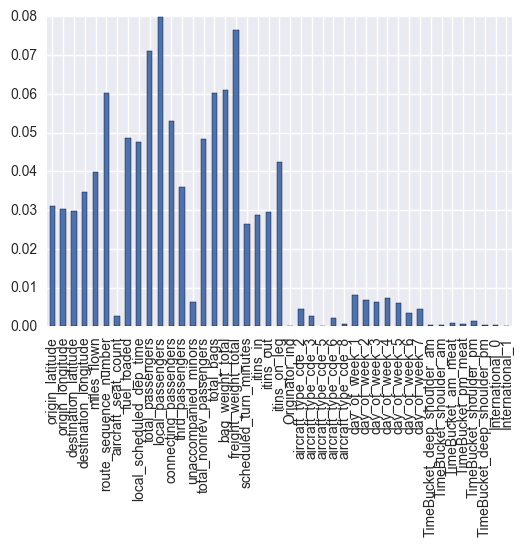

In [153]:
importances =  pd.Series(clf.feature_importances_, index = list([np.array(X.columns.values)]))

ax = importances.plot(kind = 'bar')


It is interesting that this model has very different feature importances than the logistic regression.  The importances of the logistic regression seemed to make a bit more sense from the position of practical significance. 

In [166]:
# let's make a graphic for this model

from sklearn.tree import export_graphviz

export_graphviz(clf, out_file = 'tree.dot')

Wow!  The graphic (not shown here) is so complex that graphviz had to shrink the image and it is not even intelligible.  Let's just see what a simplified model gives us with the most important variables and limited depth.  The tree can be viewed in the github repository for this report (https://github.com/dpmurraygt/OnTime.git)

In [199]:
%%time


yhat = np.zeros(Y.shape)

cv = StratifiedKFold(n_splits=10) 

clf = DecisionTreeClassifier(criterion ='entropy', max_depth = 6 ) # old was 6

for train, test in cv.split(XScl2,Y):
    clf.fit(XScl2[train],Y[train])
    yhat[test] = clf.predict(XScl2[test])

total_accuracy = mt.accuracy_score(Y,yhat)
conf_matrix = mt.confusion_matrix(Y,yhat)

precision = conf_matrix[0,0] / (conf_matrix[0,0]+ conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0]+ conf_matrix[0,1])
f_measure = (2* conf_matrix[0,0]) / ((2* conf_matrix[0,0])+ conf_matrix[0,1] + conf_matrix[1,0])

print('-------------------------------')
print('Decision Tree Output')
print( total_accuracy)
print(conf_matrix)
print('Precision: ',precision, 'Recall: ',recall, 'F-measure: ', f_measure)

-------------------------------
Decision Tree Output
0.821394804376
[[   37 19803]
 [   32 91183]]
Precision:  0.536231884058 Recall:  0.00186491935484 F-measure:  0.00371691194937
Wall time: 874 ms


It is very interesting that our simplified decision tree did much better than the more complex model.  Notice though, that the tree figured out that it can forecast the false features correctly and make a model that appears to be really good.  Let's make a visual of the output.  However, recall fell off of a cliff and our f-measure is pretty poor.

In [195]:
from sklearn.tree import export_graphviz

export_graphviz(clf, out_file = 'tree2.dot', feature_names = ['origin_longitude', 'local_scheduled_dep_time',
                                                              'Originator_ind','scheduled_turn_minutes',
                                                              'aircraft_seat_count'])

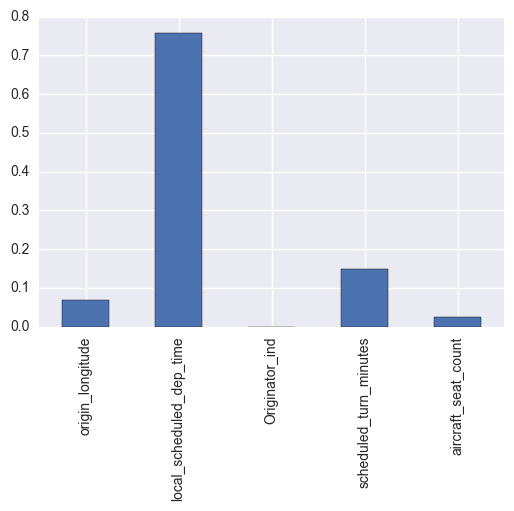

In [201]:
importances =  pd.Series(clf.feature_importances_, index = ['origin_longitude', 'local_scheduled_dep_time',
                                                              'Originator_ind','scheduled_turn_minutes',
                                                              'aircraft_seat_count'] )

ax = importances.plot(kind = 'bar')


In [202]:
yhat = np.zeros(Y.shape)

X3 = X[[ 'local_scheduled_dep_time','scheduled_turn_minutes']]

scl = StandardScaler() # import the standardscaler
XScl3 = scl.fit_transform(X3)


cv = StratifiedKFold(n_splits=10) 

clf = DecisionTreeClassifier(criterion ='entropy', max_depth = 6 ) # old was 6

for train, test in cv.split(XScl3,Y):
    clf.fit(XScl3[train],Y[train])
    yhat[test] = clf.predict(XScl3[test])

total_accuracy = mt.accuracy_score(Y,yhat)
conf_matrix = mt.confusion_matrix(Y,yhat)

precision = conf_matrix[0,0] / (conf_matrix[0,0]+ conf_matrix[1,0])
recall = conf_matrix[0,0] / (conf_matrix[0,0]+ conf_matrix[0,1])
f_measure = (2* conf_matrix[0,0]) / ((2* conf_matrix[0,0])+ conf_matrix[0,1] + conf_matrix[1,0])

print('-------------------------------')
print('Decision Tree Output')
print( total_accuracy)
print(conf_matrix)
print('Precision: ',precision, 'Recall: ',recall, 'F-measure: ', f_measure)

-------------------------------
Decision Tree Output
0.82134978164
[[    0 19840]
 [    0 91215]]
Precision:  nan Recall:  0.0 F-measure:  0.0


In [ ]:
Well, the output makes no sense.  We are now not classifying anything as posi

In [156]:
%%time

#Basic Logistic Regression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ShuffleSplit

yhat = np.zeros(Y.shape) # we will fill this with predictions

scl = StandardScaler()
XScl = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
clf = GaussianNB()

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv.split(XScl,Y):
    #print("X NAN", np.any(np.isnan(XScl[train])))
    #print("X Finite", np.any(np.isfinite(XScl[train])))
    #print("Y NAN", np.any(np.isnan(Y[train])))
    #print("Y Finite", np.any(np.isfinite(Y[train])))
    clf.fit(XScl[train],Y[train])
    yhat[test] = clf.predict(XScl[test])
 
    
total_accuracy = mt.accuracy_score(Y, yhat)
print ('Logistic Regression', total_accuracy)

Logistic Regression 0.728242762595
CPU times: user 14.2 s, sys: 7.48 s, total: 21.7 s
Wall time: 24.7 s


In [158]:
%%time

#Basic Logistic Regression with PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import ShuffleSplit

yhat = np.zeros(Y.shape) # we will fill this with predictions

scl = StandardScaler()
XScl = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)


# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=150,svd_solver='randomized')),
     ('CLF',GaussianNB())]
)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv.split(XScl,Y):
    #print("X NAN", np.any(np.isnan(XScl[train])))
    #print("X Finite", np.any(np.isfinite(XScl[train])))
    #print("Y NAN", np.any(np.isnan(Y[train])))
    #print("Y Finite", np.any(np.isfinite(Y[train])))
    clf_pipe.fit(XScl[train],Y[train])
    yhat[test] = clf_pipe.predict(XScl[test])
 
    
total_accuracy = mt.accuracy_score(Y, yhat)
print ('Logistic Regression with PCA', total_accuracy)

Logistic Regression 0.822925577417
CPU times: user 4min 28s, sys: 22.6 s, total: 4min 51s
Wall time: 3min 42s


In [160]:
%%time

#Random Forest with PCA
from sklearn.ensemble import RandomForestClassifier

yhat = np.zeros(Y.shape) # we will fill this with predictions

scl = StandardScaler()
XScl = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)


# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',PCA(n_components=150,svd_solver='randomized')),
     ('CLF',RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1))]
)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv.split(XScl,Y):
    #print("X NAN", np.any(np.isnan(XScl[train])))
    #print("X Finite", np.any(np.isfinite(XScl[train])))
    #print("Y NAN", np.any(np.isnan(Y[train])))
    #print("Y Finite", np.any(np.isfinite(Y[train])))
    clf_pipe.fit(XScl[train],Y[train])
    yhat[test] = clf_pipe.predict(XScl[test])
 
    
total_accuracy = mt.accuracy_score(Y, yhat)
print ('Random Forest Classifier', total_accuracy)



Logistic Regression 0.870712709919
CPU times: user 1h 25min 44s, sys: 41.7 s, total: 1h 26min 25s
Wall time: 45min 43s


In [153]:
%%time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


yhat = np.zeros(Y.shape) # we will fill this with predictions

scl = StandardScaler()
XScl = scl.fit_transform(X)

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=5)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv.split(XScl,Y):
    clf.fit(XScl[train],Y[train])
    yhat[test] = clf.predict(XScl[test])
 
    
total_accuracy = mt.accuracy_score(Y, yhat)
print ('KNN', total_accuracy)

NameError: name 'Stratified' is not defined

In [119]:
yhat

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
# logistic regression?



In [ ]:
# KD tree?

In [ ]:
# Decision Tree?

In [ ]:
#Naive Bayes

In [ ]:
#KNN

#%%time

# setup pipeline to take PCA, then fit a KNN classifier
clf_pipe = Pipeline(
    [('PCA_Eric',PCA(n_components=200)),
     ('CLF_Eric',KNeighborsClassifier(n_neighbors=1))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,Y):
    clf_pipe.fit(X[train],Y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(Y, yhat)
print ('KNN, pipeline accuracy', total_accuracy)

In [ ]:
#Random Forest